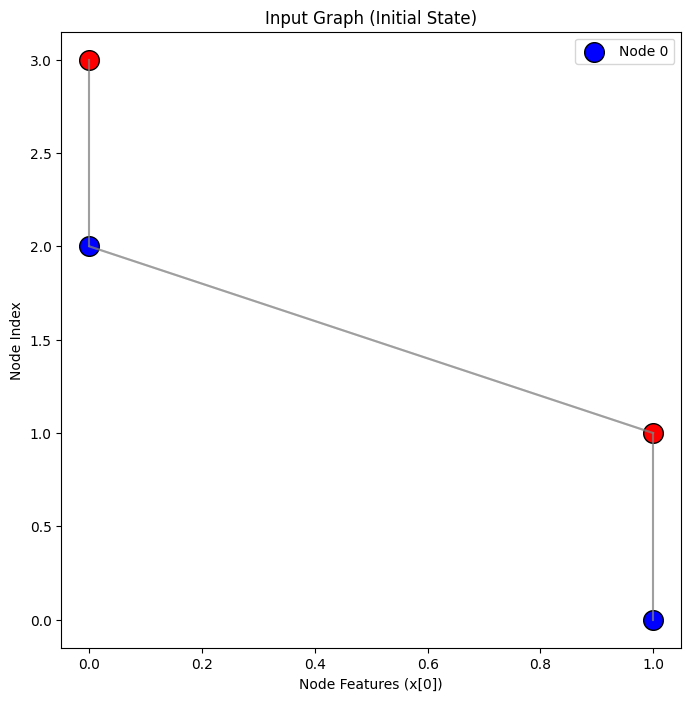

Epoch 1/1000, Loss: 0.6880
Epoch 21/1000, Loss: 0.6591
Epoch 41/1000, Loss: 0.6493
Epoch 61/1000, Loss: 0.6471
Epoch 81/1000, Loss: 0.6458
Epoch 101/1000, Loss: 0.6440
Epoch 121/1000, Loss: 0.6400
Epoch 141/1000, Loss: 0.6331
Epoch 161/1000, Loss: 0.6228
Epoch 181/1000, Loss: 0.6103
Epoch 201/1000, Loss: 0.5973
Epoch 221/1000, Loss: 0.5843
Epoch 241/1000, Loss: 0.5717
Epoch 261/1000, Loss: 0.5607
Epoch 281/1000, Loss: 0.5508
Epoch 301/1000, Loss: 0.5430
Epoch 321/1000, Loss: 0.5364
Epoch 341/1000, Loss: 0.5311
Epoch 361/1000, Loss: 0.5269
Epoch 381/1000, Loss: 0.5237
Epoch 401/1000, Loss: 0.5210
Epoch 421/1000, Loss: 0.5190
Epoch 441/1000, Loss: 0.5174
Epoch 461/1000, Loss: 0.5161
Epoch 481/1000, Loss: 0.5148
Epoch 501/1000, Loss: 0.5140
Epoch 521/1000, Loss: 0.5134
Epoch 541/1000, Loss: 0.5127
Epoch 561/1000, Loss: 0.5121
Epoch 581/1000, Loss: 0.5118
Epoch 601/1000, Loss: 0.5116
Epoch 621/1000, Loss: 0.5113
Epoch 641/1000, Loss: 0.5111
Epoch 661/1000, Loss: 0.5108
Epoch 681/1000, Loss

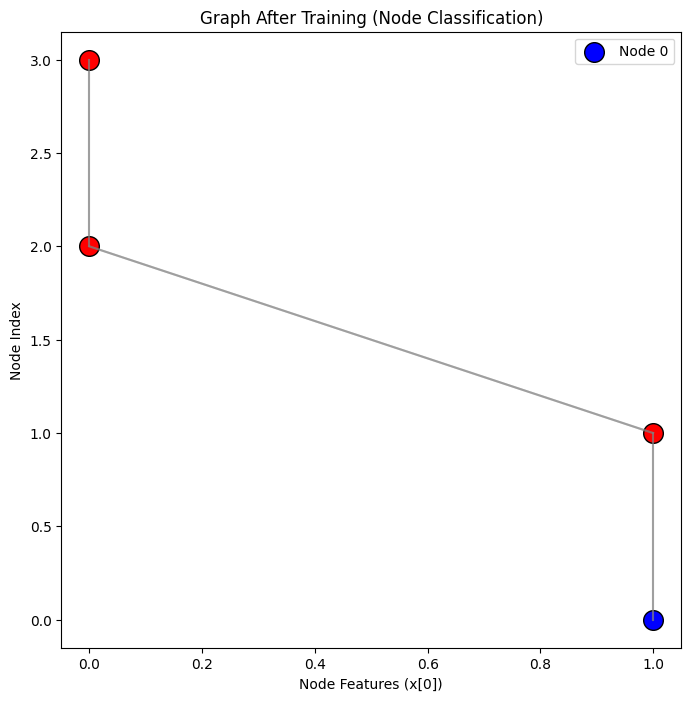

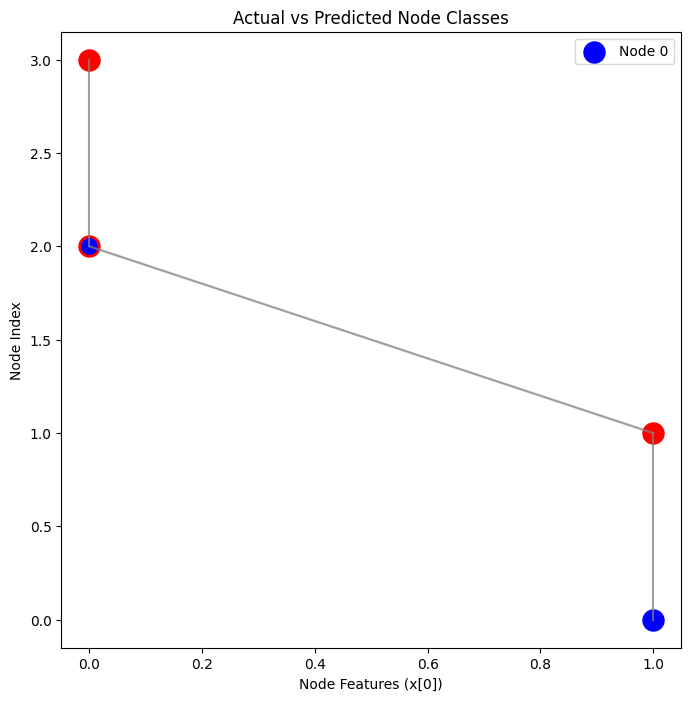

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Step 1: Create a simple graph dataset
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3],
    [1, 0, 2, 1, 3, 2]
], dtype=torch.long)

# Node features (4 nodes, 1 feature each)
x = torch.tensor([[1], [1], [0], [0]], dtype=torch.float)

# Labels for nodes (classification target, e.g., 0 or 1 for binary classification)
y = torch.tensor([0, 1, 0, 1], dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Step 2: Define the GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)  # First GCN layer with 16 output features
        self.conv2 = GCNConv(16, out_channels)  # Second GCN layer with output features equal to number of classes

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))  # Apply first GCN layer + ReLU
        x = self.conv2(x, data.edge_index)  # Apply second GCN layer
        return x

# Step 3: Instantiate the model, define loss and optimizer
model = GCN(in_channels=1, out_channels=2)  # 1 input feature, 2 output classes
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Step 4: Training the model
def train(model, data, optimizer, criterion, epochs=1000):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear gradients
        out = model(data)  # Forward pass
        loss = criterion(out, data.y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        if epoch % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Function to visualize the graph
def visualize_graph(data, title, labels=None, predictions=None, show_comparison=False):
    plt.figure(figsize=(8, 8))

    # Extract node positions (for simplicity, use node indices as y-coordinates)
    node_positions = {i: (data.x[i, 0].item(), i) for i in range(data.num_nodes)}

    # Plot edges
    for i, j in data.edge_index.t():  # Iterate over edges
        src, tgt = node_positions[i.item()], node_positions[j.item()]
        plt.plot([src[0], tgt[0]], [src[1], tgt[1]], 'gray', alpha=0.5)

    # Plot nodes
    for i in range(data.num_nodes):
        if show_comparison:
            # Use dual colors: actual label as fill, predicted as edge
            fill_color = 'r' if labels[i] == 1 else 'b'
            edge_color = 'r' if predictions[i] == 1 else 'b'
            plt.scatter(
                node_positions[i][0], node_positions[i][1],
                color=fill_color, s=200, edgecolor=edge_color, linewidth=2,
                label=f'Node {i}' if i == 0 else ""
            )
        else:
            color = 'r' if (predictions[i] if predictions is not None else labels[i]) == 1 else 'b'
            plt.scatter(
                node_positions[i][0], node_positions[i][1],
                color=color, s=200, edgecolor='k', label=f'Node {i}' if i == 0 else ""
            )

    # Adjust legend and plot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.xlabel('Node Features (x[0])')
    plt.ylabel('Node Index')
    plt.show()

# Visualize the graph before training
visualize_graph(data, "Input Graph (Initial State)", labels=data.y)

# Train the model
train(model, data, optimizer, criterion)

# Step 5: Evaluate the model
model.eval()
with torch.no_grad():  # Disable gradient computation during inference
    out = model(data)
    _, pred = out.max(dim=1)  # Get the class with the highest score
    accuracy = (pred == data.y).sum().item() / data.num_nodes  # Calculate accuracy
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualize the graph after training
visualize_graph(data, "Graph After Training (Node Classification)", predictions=pred)

# Visualize actual vs predicted node classes
visualize_graph(data, "Actual vs Predicted Node Classes", labels=data.y, predictions=pred, show_comparison=True)
